In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

## Import Data

In [2]:
features = pd.read_csv('../../walmart-recruiting-store-sales-forecasting/features/features.csv')

train = pd.read_csv('../../walmart-recruiting-store-sales-forecasting/train/train.csv')
train['Date'] = pd.to_datetime(train['Date'])

test = pd.read_csv('../../walmart-recruiting-store-sales-forecasting/test/test.csv')
test['Date'] = pd.to_datetime(test['Date'])

stores = pd.read_csv('../../walmart-recruiting-store-sales-forecasting/stores.csv')

In [3]:
print(features.head())
print("------------------------------------------------------------/n")
print(stores.head())
print("------------------------------------------------------------/n")
print(train.head())
print("------------------------------------------------------------/n")
print(test.head())
print("------------------------------------------------------------/n")

   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False  
------------------------------------------------------------/n
   Store Type    Size
0      1    A  151315
1      2    A  202307


In [4]:
features.shape, train.shape, stores.shape, test.shape

((8190, 12), (421570, 5), (45, 3), (115064, 4))

In [5]:
print(train.info())
print("------------------------------------------------------------/n")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB
None
------------------------------------------------------------/n
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Store      115064 non-null  int64         
 1   Dept       115064 non-null  int64         
 2   Date       115064 non-null  datetime64[ns]
 3   IsHoliday  115064 non-null  boo

## Data Extraction
Walmart Sales

In [6]:
feat_stores = features.merge(stores, how='inner', on = "Store")

feat_stores['Date'] = pd.to_datetime(feat_stores['Date'])

feat_stores['Day'] = feat_stores['Date'].dt.day
feat_stores['Week'] = feat_stores['Date'].dt.week
feat_stores['Month'] = feat_stores['Date'].dt.month
feat_stores['Year'] = feat_stores['Date'].dt.year

train_df = train.merge(feat_stores, how='inner', on = ['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)
test_df = test.merge(feat_stores, how='inner', on = ['Store','Date','IsHoliday']).sort_values(by = ['Store','Dept','Date']).reset_index(drop=True)

C:\Users\brock\AppData\Local\Temp\ipykernel_34760\1066139146.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  feat_stores['Week'] = feat_stores['Date'].dt.week


## Data Exploration

### Sales By Week
This graph shows the combined sales for each store during a full year by week. This gives us an idea of rises/falls in sales during holidays. 

In [7]:
df_weeks = train_df.groupby('Week').sum()

px.line( data_frame = df_weeks, x = df_weeks.index, y = 'Weekly_Sales', 
        labels = {'Weekly_Sales' : 'Weekly Sales', 'x' : 'Weeks' }, 
        title = 'Sales per week')

C:\Users\brock\AppData\Local\Temp\ipykernel_34760\2800950971.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weeks = train_df.groupby('Week').sum()


In [8]:
weekly_sales = train_df.groupby(['Year','Week'], as_index = False).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2010 = train_df.loc[train_df['Year']==2010].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2011 = train_df.loc[train_df['Year']==2011].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})

weekly_sales2012 = train_df.loc[train_df['Year']==2012].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})

### Sales by Week, 2010-12

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = weekly_sales2010['Weekly_Sales']['mean'].index, y = weekly_sales2010['Weekly_Sales']['mean'], name = 'Mean Sales 2010', mode = 'lines') )
fig.add_trace(go.Scatter( x = weekly_sales2011['Weekly_Sales']['mean'].index, y = weekly_sales2011['Weekly_Sales']['mean'], name = 'Mean Sales 2011', mode = 'lines') )
fig.add_trace(go.Scatter( x = weekly_sales2012['Weekly_Sales']['mean'].index, y = weekly_sales2012['Weekly_Sales']['mean'], name = 'Mean Sales 2012', mode = 'lines') )
fig.update_layout(title = 'Sales 2010, 2011, 2012', xaxis_title = 'Weeks')


## Markdown and Sales

How do markdowns affect weekly sales?

By nature, Markdowns contain missing values. This may need to be taken into account before modeling. Let's see how many NaN values are found in the current data.

In [10]:
print(train_df.isnull().sum())

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
Day                  0
Week                 0
Month                0
Year                 0
dtype: int64


In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown1'], name = 'MarkDown1', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown2'], name = 'MarkDown2', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown3'], name = 'MarkDown3', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown4'], name = 'MarkDown4', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown5'], name = 'MarkDown5', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['Weekly_Sales'], name = 'Weekly Sales', mode = 'lines') )
fig.update_layout(title = "Sales vs Markdown's", xaxis_title = 'Weeks')

## Correlation between features and Sales
Which features affect sales the most/least?

C:\Users\brock\AppData\Local\Temp\ipykernel_34760\3692685819.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



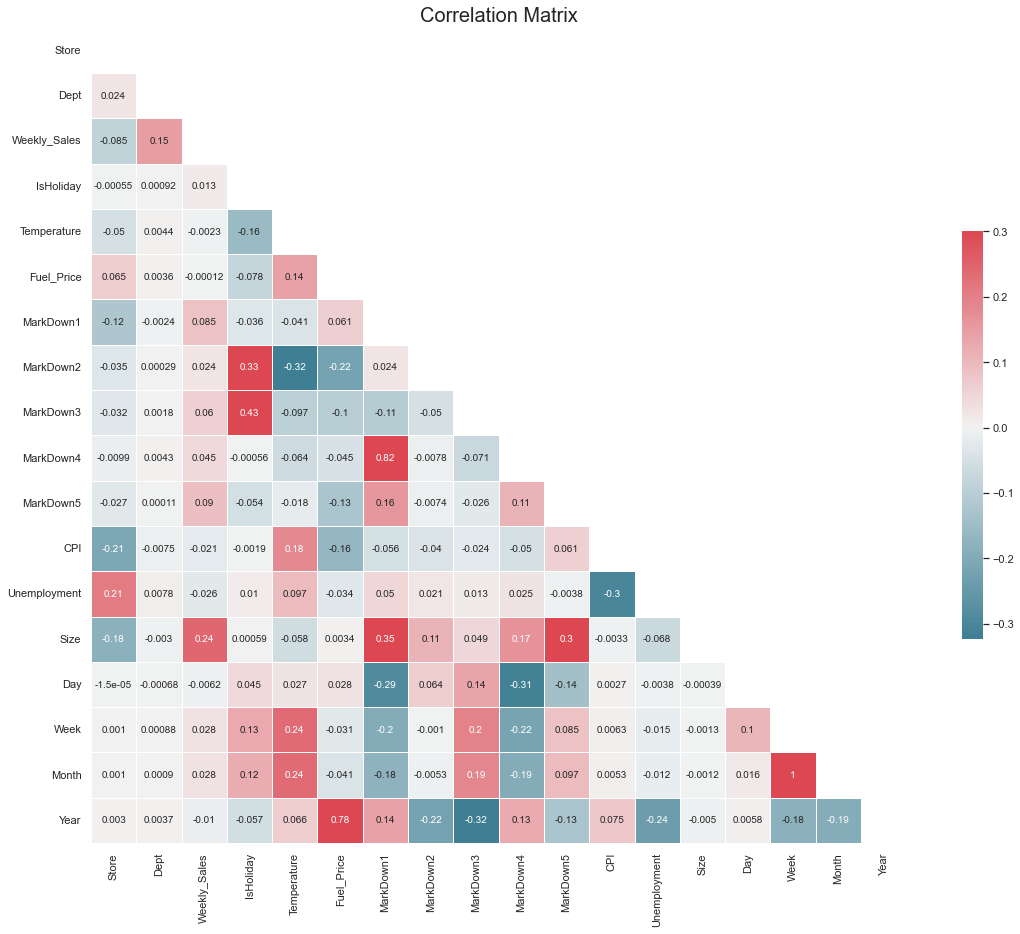

In [12]:
sns.set(style="white")
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=20)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

The more **positive**, the more **correlated**.

The more **negative**, the more **unrelated**.

See the below graph for a summary of correlation results.

In [13]:
weekly_sales_corr = train_df.corr().iloc[2,:]
corr_df = pd.DataFrame(data = weekly_sales_corr, index = weekly_sales_corr.index ).sort_values (by = 'Weekly_Sales', ascending = False)
corr_df = corr_df.iloc[1:]
bar = px.bar(corr_df, x = corr_df.index, y = 'Weekly_Sales', color=corr_df.index, labels={'index':'Featues'},
             title='Feature correlation with Weekly_Sales')
bar.update_traces(showlegend=False)

C:\Users\brock\AppData\Local\Temp\ipykernel_34760\3944548364.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Based on the above graph, Store Size Store Type are most correlated with Weekly Sales

Markdowns 5, 4, 3 are the next-best correlated features, with Markdown 2 being the least-constributing of the Markdowns.

Fuel Price, Temperature, CPI, and Unemployment are not positively correlated with Weekly Sales, so in the future, we may consider dropping these features before modeling.